# Analyse your transcript
What kind of behaviour would you like to analyse in your transcript? Use ChatGPT or any equivalent LLM-based application to give you a list of terms that relate to this particular behaviour. Use the prompt below if you like, or use your own.

---
#### NOTE:  
Replace **'______'** in the prompt below with a term that best describes the kind of behaviour you'd like to examine.

### Prompt to use:

Generate a list of words that could be used in a LIWC-like dictionary to identify instances of ______ in a transcript of a conversation between two or more people. Do not use wildcard characters, provide all inflected forms of words that might otherwise appear in a LIWC dictionary as wildcards. Make sure the list is all in lowercase, ordered alphabetically, with each set of inflected forms of a word together on the same line. Output this in the form of a list of strings that can be copied and pasted into python code as a list.

---


In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import Markdown, display

## Define your measure terms and give the measure a name

In [2]:
# copy the output from the LLM and paste it next to the variable named "measure_words" below 
# Make sure you have also copied the square braces [ ] that were part of the LLM output.

measure_words = [
    "analyze", "analyzes", "analyzing", "analyzed", "analysis", "analyses",
    "assume", "assumes", "assuming", "assumed", "assumption", "assumptions",
    "because",
    "compare", "compares", "comparing", "compared", "comparison", "comparisons",
    "conclude", "concludes", "concluding", "concluded", "conclusion", "conclusions",
    "consider", "considers", "considering", "considered", "consideration",
    "decide", "decides", "deciding", "decided", "decision", "decisions",
    "deduce", "deduces", "deducing", "deduced", "deduction", "deductions",
    "determine", "determines", "determining", "determined", "determination",
    "examine", "examines", "examining", "examined", "examination",
    "explain", "explains", "explaining", "explained", "explanation", "explanations",
    "figure", "figures", "figuring", "figured",
    "hence",
    "how",
    "identify", "identifies", "identifying", "identified", "identification",
    "infer", "infers", "inferring", "inferred", "inference", "inferences",
    "interpret", "interprets", "interpreting", "interpreted", "interpretation", "interpretations",
    "justify", "justifies", "justifying", "justified", "justification", "justifications",
    "logic", "logical", "logically",
    "meaning", "meanings",
    "reason", "reasons", "reasoning", "reasoned",
    "reflect", "reflects", "reflecting", "reflected", "reflection", "reflections",
    "so",
    "determine", "determines", "determining", "determined", "determination",
    "therefore",
    "think", "thinks", "thinking", "thought", "thoughts",
    "thus",
    "understand", "understands", "understanding", "understood",
    "why"
]

# Give your measure a single- or two-word name. 
# Replace the 'XXXX' below with the name.
# Make sure the name is enclosed in single or double quotation marks
measure_name = 'reasoning'

# Load Transcript

In [3]:
transcript_df = pd.read_excel('data/sample_transcript.xlsx')
print('###############################################')
print("Loaded", transcript_df.shape[0], "speech turns into a dataframe.")
print('###############################################')
# Print a random sample of the dataframe, showing 5 rows.
transcript_df.sample(5)

###############################################
Loaded 747 speech turns into a dataframe.
###############################################


,timestamp,speaker,utterance
736,00:50:27,Alpha,"No, it's half."
74,00:03:58,Alpha,Just put them on the wall.
498,00:33:54,Bravo,The beak.
703,00:48:33,Alpha,"No, I think if I touch it and it will fall apart."
66,00:03:42,Alpha,A duck.


## Counting Relevant Terms in the Dataset
We now count the number of terms in each utterance that also exist in the above list of measure-related terms.

In [4]:
def make_regex(lex_list):
    separator = '\\b|\\b'
    reg_string = separator.join(lex_list)
    reg_string_whole_word = "\\b" + reg_string + "\\b"
    return reg_string_whole_word

def count_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    num_matches = len(list(re.finditer(reg_str, sentence.lower())))
    return num_matches

def count_words(sentence):
    words = sentence.split()
    return len(words)

In [5]:
def add_measure(df, lex_category_name, lex_category_list):
    if lex_category_name in df.columns :
        print("Column already exists for", lex_category_name, ". Repopulating...")
        df = df.drop(lex_category_name, axis=1)
    column_index = len(df.columns)
    measures = []
    measures_normalized = []
    word_counts = []
    for ind, utterance in enumerate(list(df['utterance'])) :
        if utterance != '' and utterance != ' ' :
            measure = count_lexicon_terms(utterance, lex_category_list)
            num_words = count_words(utterance)
            word_counts.append(num_words)
            measures_normalized.append(measure/num_words)
            measures.append(measure)
    df.insert(column_index, 'normalized '+lex_category_name+' measure', measures_normalized, True)
    df.insert(column_index, lex_category_name+' count', measures, True)
    if not 'word count' in df.columns :
        df.insert(column_index, 'word count', word_counts, True)
    return df

In [6]:
transcript_df = add_measure(transcript_df, measure_name, measure_words)

In [7]:
transcript_df.sample(5)

,timestamp,speaker,utterance,word count,reasoning count,normalized reasoning measure
428,00:28:46,Unclear,"['00:28:53', 'Alpha']",2,0,0.0
42,00:02:33,Alpha,Like... 3D or on the wall?,6,0,0.0
734,00:50:12,Alpha,"It was a lot of yellow, yeah.",7,0,0.0
517,00:35:46,Bravo,Yes it does.,3,0,0.0
330,00:20:44,Bravo,I am not sure.,4,0,0.0


## Overview of speaker participation

In [8]:
speakers = list(set(transcript_df['speaker'].to_list()))
num_speakers = len(speakers)
word_count_df = transcript_df[['speaker', 'word count']].copy()
word_count_df['total word count'] = word_count_df.groupby('speaker')['word count'].transform('sum')
word_count_df = word_count_df[['speaker', 'total word count']].drop_duplicates()
word_count_df = word_count_df.sort_values("total word count", ascending=False)

turn_counts = []
for speaker in speakers :
    turn_count = transcript_df[transcript_df['speaker'] == speaker].shape[0]
    turn_counts.append(turn_count)
turns_df = pd.DataFrame({'speaker': speakers, 'turn count': turn_counts})
speaker_stats_df = pd.merge(word_count_df, turns_df, on="speaker")

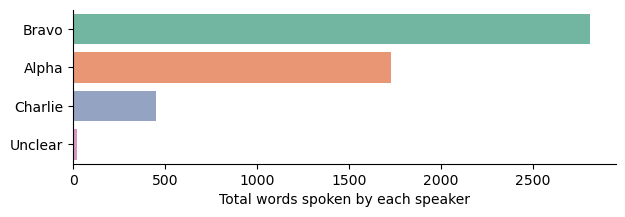

In [9]:
f, ax = plt.subplots(figsize=(7, num_speakers*0.5))
sns.barplot(data=speaker_stats_df, x='total word count', y='speaker', hue='speaker', palette ='Set2', linewidth=0)
ax.set(ylabel="", xlabel="Total words spoken by each speaker")
sns.despine(right=True, top=True)

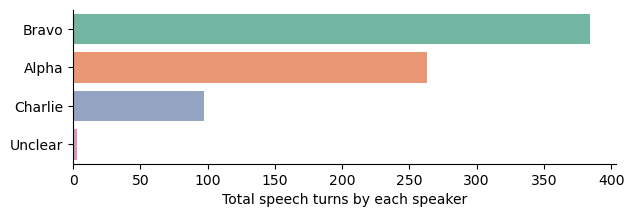

In [10]:
f, ax = plt.subplots(figsize=(7, num_speakers*0.5))
sns.barplot(data=speaker_stats_df, x='turn count', y='speaker', hue='speaker', palette ='Set2', linewidth=0)
ax.set(ylabel="", xlabel="Total speech turns by each speaker")
sns.despine(right=True, top=True)

<Figure size 1920x1440 with 0 Axes>

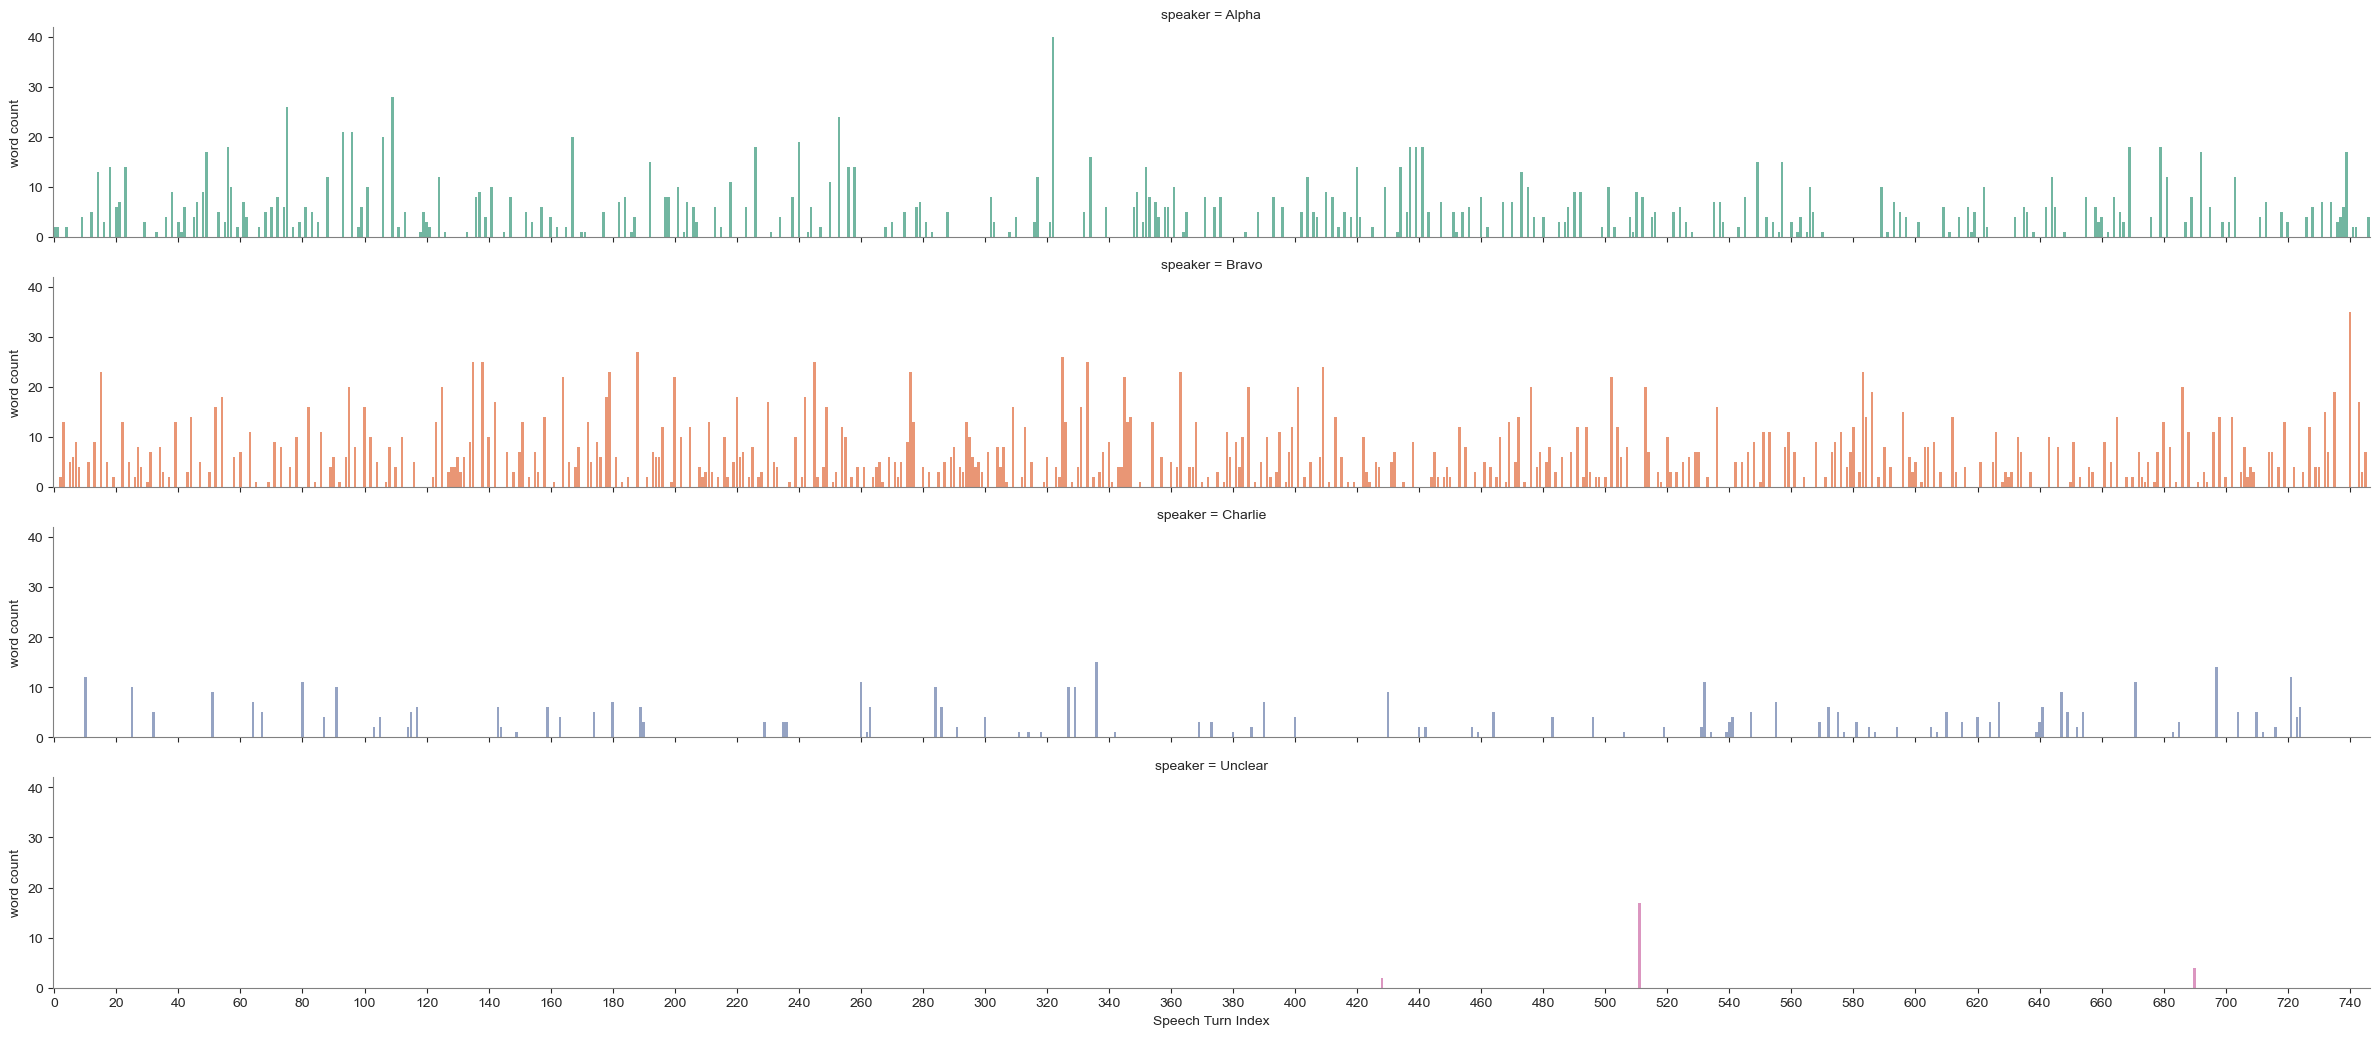

In [11]:
session_turns = transcript_df.shape[0]
transcript_df['turn index'] = np.arange(0,session_turns)
fig = plt.figure( dpi=300)
sns.set_style('ticks', {'axes.linewidth': 0.5, 'axes.edgecolor':'grey', 'axes.spinecolor' : 'grey'})
# sns.set_context('talk', font_scale = 1)
g = sns.FacetGrid(transcript_df, row="speaker", hue='speaker', palette ='Set2', aspect=8)
g.map_dataframe(sns.barplot, x =transcript_df["turn index"], y="word count", linewidth=0)
p = plt.xticks(np.arange(0, session_turns, 20))
plt.xlabel('Speech Turn Index')
# plt.title("Word count for each speaker over the duration of the conversation", fontsize=14)
plt.savefig('./plots/speech_turns.pdf', bbox_inches='tight')

In [12]:
def plot_measure(df1, measure, show_all=False):
    session_turns = df1.shape[0]
    df1['zero_index'] = np.arange(0,session_turns)
    fig = plt.figure(figsize=[round(session_turns/20),4], dpi=300)
    col = sns.color_palette("Set2")
    sns.set_style('ticks', {'axes.linewidth': 0.5, 'axes.edgecolor':'grey', 'axes.spinecolor' : 'grey'})
    sns.set_context('paper', font_scale = 1)
    if show_all :
        sns.barplot(x=df1.zero_index, y='word count', data=df1, color ='#eee', linewidth=0)
        ax = sns.barplot(x=df1.zero_index, y=measure+' count', data=df1, hue='speaker', palette ='Set2', linewidth=0)
        plt.title("Speech turn-wise word count with non-normalised measure for: " + measure, fontsize=9)
    else :
        ax = sns.barplot(x=df1.zero_index, y='normalized '+measure+' measure', data=df1, hue='speaker', palette ='Set2', linewidth=0)
        plt.title("Speech turn-wise normalised measure for: " + measure, fontsize=13)
        
    plt.xticks(np.arange(0, session_turns, 20))
    ax.set_ylabel(measure, fontsize=9)
    speakers = len(set(list(df1['speaker'])))
    legend_columns = round(speakers/4) + 1
    plt.legend(loc='best', ncol=legend_columns, borderaxespad=0.15)
    plt.savefig('./plots/'+ measure +'.pdf', bbox_inches='tight')
    plt.show()

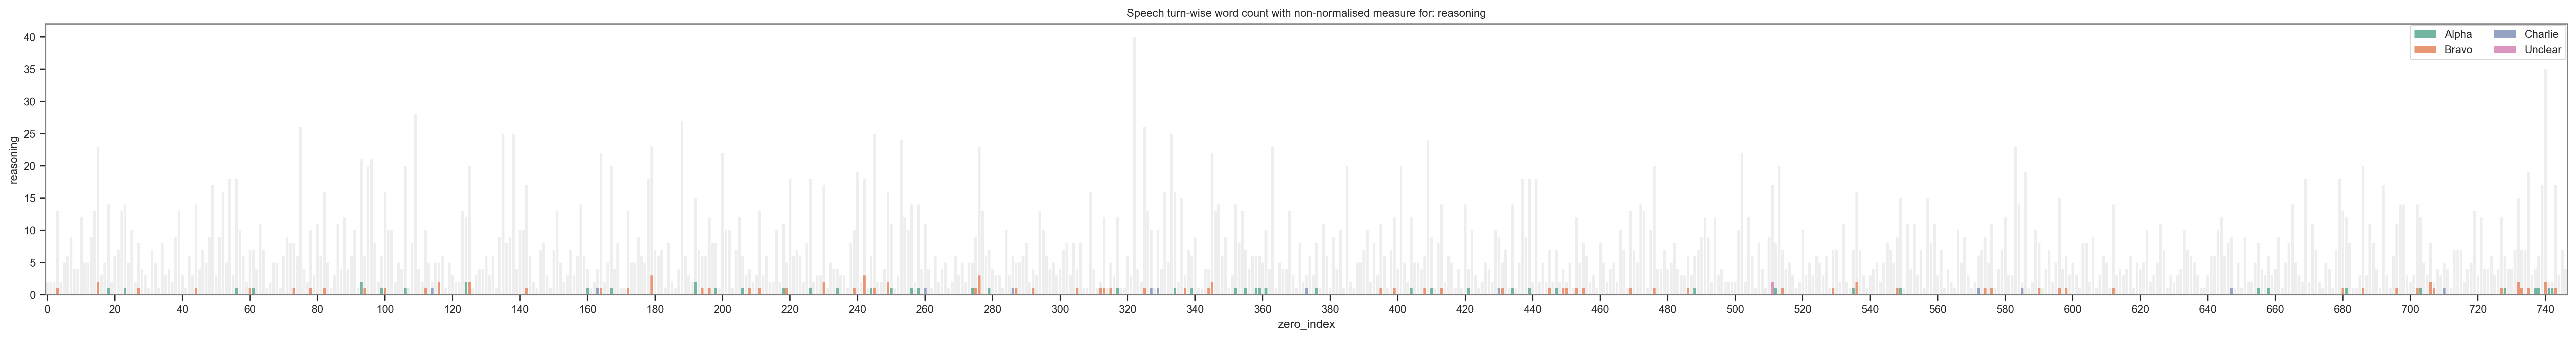

In [13]:
plot_measure(transcript_df, measure_name, show_all=True)

In [14]:
def printmd(string):
    display(Markdown(string))

def match_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    reg_matches = re.findall(reg_str, sentence.lower())
    reg_split = re.split(reg_str, sentence.lower())
    ind = 0
    matched_print = ""
    for split_string in reg_split:
        if ind == len(reg_matches) :
            str_to_concat = split_string
        else :
            str_to_concat = split_string + '**' + reg_matches[ind] + '**'
            ind += 1
        matched_print += str_to_concat
    return matched_print
    
def print_lines(df2, lexicon, start, num_lines=10):
    speakers_list = list(df2['speaker'])
    utt = list(df2['utterance'])
    end = start + num_lines
    for ind, line in enumerate(utt[start:end]) :
        index = ind + start
        line_matched = match_lexicon_terms(line, lexicon)
        print(str(index)+' : ', end='')
        print(speakers_list[index])
        printmd(line_matched)
        print('----------')
        
def concordance(text, word, width=80, occurrences=10,nospace=False):
    margin = int((width - len(word))/2)
    start = 0
    counter = 0
    while start < len(text) or counter == occurrences:
        ind = text.find(word, start, -1)
        if ind < 0 :
            break
        
        if nospace : 
            
            if ind - margin > 0 :
                print(text[ind-margin:ind+len(word)+margin], ":", str(ind))
            else :
                spaces = ' ' * (margin - ind)
                print(spaces + text[0:ind+len(word)+margin], ":", str(ind))
            
        else :
            
            if ind - margin > 0 :
                left_text = text[ind-margin:ind]
                mid_text = text[ind:ind+len(word)]
                right_text = text[ind+len(word):ind+len(word)+margin]
            else :
                left_text = text[0:ind]
                mid_text = text[ind:ind+len(word)]
                right_text = text[ind+len(word):ind+len(word)+margin]
                
            print(left_text + "  " + mid_text + "  " + right_text, ":", str(ind))
            
        start += ind + len(word)
        counter += 1
        

def print_concordances(df2, filter_keywords, match_limit=10, nospace=False):
    speakers_list = list(df2['speaker'])
    utt = list(df2['utterance'])
    utt_str = ' '.join(utt)
    if len(filter_keywords) > 0 :
        for term in filter_keywords :
            concordance(utt_str, term, width=80, occurrences=match_limit, nospace=nospace)
            print("-" * 80)

In [15]:
print_lines(transcript_df, measure_words, 402, num_lines=10)

402 : Alpha


let's just build around it.

----------
403 : Bravo


all right.

----------
404 : Alpha


**so** we start with the back and then go to the front

----------
405 : Bravo


we can just make this.

----------
406 : Alpha


should we glue that somehow?

----------
407 : Alpha


it doesn't really stick.

----------
408 : Bravo


no, **because** i didn't overlap it.

----------
409 : Bravo


but we can use. we can use the other technique if you if you stick it on there, i'll make some more sticky parts.

----------
410 : Alpha


but it doesn't work **because** that also doesn't stick.

----------
411 : Bravo


what?

----------
